## Getting started
Upload needed libraries and setting up the dataset

In [1]:
import numpy as np
import pandas as pd
import os
import bellatrex as btrex
print("Bellatrex version:", btrex.__version__)

PLOT_GUI = False

##########################################################################
root_folder = os.getcwd()
print(root_folder)

Bellatrex version: 0.3.1
c:\Users\klest\Documents\GitHub\Bellatrex


In [2]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split


from bellatrex.datasets import load_mtr_data, load_mlc_data
from bellatrex.datasets import load_survival_data, load_binary_data, load_regression_data
from bellatrex.utilities import get_auto_setup

# X, y = load_binary_data(return_X_y=True)
# X, y = load_regression_data(return_X_y=True)
# X, y = load_survival_data(return_X_y=True)
X, y = load_mlc_data(return_X_y=True)
# X, y = load_mtr_data(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Depending on the prediction task, we train a compatible Random Forest model.

In [3]:
SETUP = get_auto_setup(y) # not necessary, but comfortable while swithcing between mnay prediction tasks
print('Detected prediction task \'SETUP\':', SETUP)

from sksurv.ensemble import RandomSurvivalForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

### instantiate original R(S)F estimator, works best with some pruning.
if SETUP.lower() in 'survival':
    clf = RandomSurvivalForest(n_estimators=100, min_samples_split=10,
                                n_jobs=-2, random_state=0)

elif SETUP.lower() in ['binary', 'multi-label']:
    clf = RandomForestClassifier(n_estimators=100, min_samples_split=5,
                                n_jobs=-2, random_state=0)

elif SETUP.lower() in ['regression', 'multi-target']:
    clf = RandomForestRegressor(n_estimators=100, min_samples_split=5,
                                n_jobs=-2, random_state=0)


clf.fit(X_train, y_train)
print('Model fitting complete.')

Detected prediction task 'SETUP': multi-label
Model fitting complete.


In case the RF model to be explained is already trained externally, it can be loaded and packed with the following lines:

In [4]:
from bellatrex.wrapper_class import pack_trained_ensemble

# Pretrained RF model should be packed as a list of dicts with the function below.
clf_packed = pack_trained_ensemble(clf)

The function `pack_trained_ensemble` stores a memory-efficient version of the model, making the model 
compatible not only with Bellatrex but also with [SHAP](https://shap.readthedocs.io/en/latest/)

The packed `clf_packed` model can now be passed into Bellatrex.

## Building Explanations
Now we can fit Bellatrex on the training data and run it on a few test samples
After fitting and tuning the explainer to a specific test instance, you can:
- `plot_overview()` to get a representation of the tree learners, and of the selected rules;
    GUI is available for this plotting method (set the paramter `plot_gui = True`).
- `plot_visuals()` to visualise the selected rules in a more use friendly way.

Model is already fitted, building explanation.
oracle_sample is: None
Automatically setting prediction task to: multi-label
Explaining sample i=0


c:\Users\klest\miniconda3\envs\btrex\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


best params: {'n_clusters': 2, 'n_dims': None, 'n_trees': 60}
Achieved fidelity: 0.7454
final trees indices: [20  1]
final cluster sizes: [29 31]
Bellatrex prediction: 0.613, 0.500, 0.129, 0.000, 1.000, 0.000, 0.000
Black box prediction: 0.669, 0.503, 0.309, 0.048, 0.855, 0.054, 0.054
##########################################################


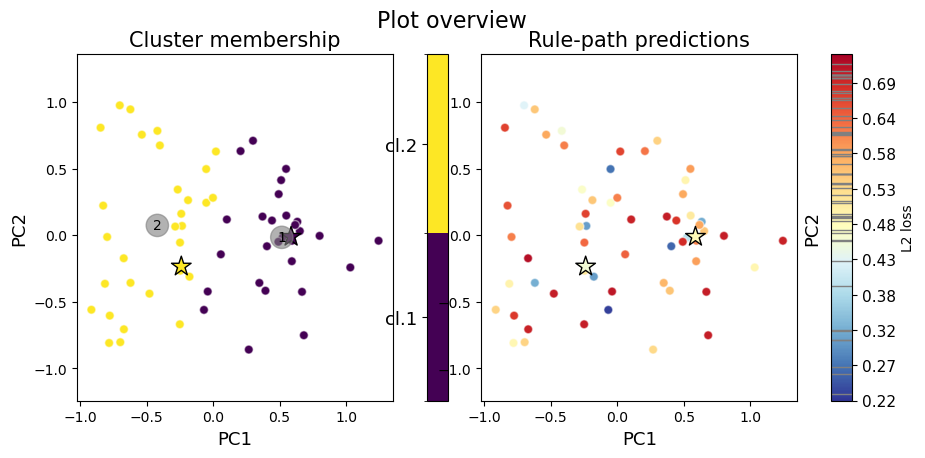

Explaining sample i=1
best params: {'n_clusters': 3, 'n_dims': None, 'n_trees': 60}
Achieved fidelity: 0.6158
final trees indices: [37 59 65]
final cluster sizes: [12 25 23]
Bellatrex prediction: 1.000, 0.896, 0.104, 0.958, 0.042, 0.000, 0.000
Black box prediction: 0.853, 0.792, 0.166, 0.706, 0.214, 0.103, 0.086
##########################################################


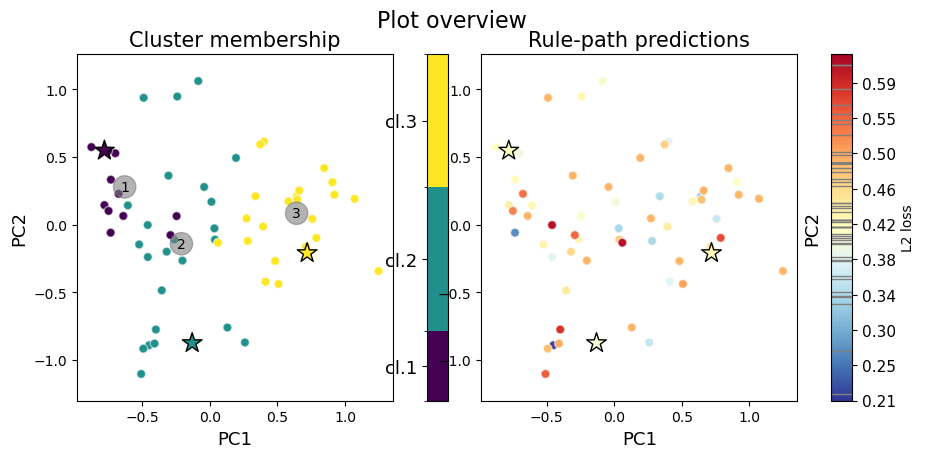

In [5]:
from bellatrex import BellatrexExplain
from bellatrex.utilities import predict_helper
import matplotlib.pyplot as plt

#fit RF here. The hyperparameters for fitting the explanation are given
# compatible with trained ensemble model clf, and with packed dictionary as in clf_packed
Btrex_fitted = BellatrexExplain(clf_packed, set_up='auto',
                                p_grid={"n_clusters": [1, 2, 3]},
                                verbose=3).fit(X_train, y_train)

N_TEST_SAMPLES = 2
for i in range(N_TEST_SAMPLES):

    print(f"Explaining sample i={i}")

    y_train_pred = predict_helper(clf, X_train) # calls, predict or predict_proba, depending on the underlying model

    tuned_method = Btrex_fitted.explain(X_test, i)

    fig1, axs1 = tuned_method.plot_overview(plot_gui=False,
                               show=True)
    plt.show(fig1)

    if SETUP.lower() in ['binary', 'regresssion', 'survival']:

        fig2, axs2 = tuned_method.plot_visuals(plot_max_depth=5,
                              preds_distr=y_train_pred,
                              conf_level=0.9,
                              tot_digits=4, show=False)
        plt.show(fig2)


## Using `nbstripout` to Strip Jupyter Notebook Metadata

During developing and testing, this notebook might undergo changes. To prevent metadata (e.g execution_count) from being synchronized by Git, we need to install `nbstripout`, and we therefore add it to the `dev` dependencies. 

This will ensure that the `pip install nbstripout` is called while pip installing `bellatrex`
### Configuration and installation

To configure behaviour we created a `.nbstripout.json` file, and placed in the root of the repo.
The path is not always recognized, so you might need to run a bash command like the following:
```
/c/Users/path/to/Scripts/nbstripout.exe --install
```

This installs a pre-commit Git hook that strips notebooks automatically when committing.

Finally the last difficult step consists in stripping the metadata from all notebooks. With (Git) bash:
```
find . -name "*.ipynb" -exec /c/Users/path/to/anaconda3/envs/btrex/Scripts/nbstripout.exe {} \;
```

You can now git add and git commit as usual! `nbstripout` will take care of stripping the metadata during its pre-commit checks.

